In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import metrics
from scipy.special import factorial
from scipy.stats.distributions import chi2

import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Loading Data

In [2]:
cm = 3
mN = 1
V2 = 1e-6

In [3]:
df_eff = pd.read_csv("../data/eff_table.csv")

In [4]:
eff_tM = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN) & (df_eff.Type=='tM')]['Efficiency'].values[0]
eff_sM = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN) & (df_eff.Type=='sM')]['Efficiency'].values[0]
eff_tD = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN) & (df_eff.Type=='tD')]['Efficiency'].values[0]
eff_sD = df_eff[(df_eff.Energy==cm) & (df_eff.Mass==mN) & (df_eff.Type=='sD')]['Efficiency'].values[0]
eff_b = df_eff[(df_eff.Energy==cm) & (df_eff.Type=='b')]['Efficiency'].values[0]

In [5]:
Lumi = 1000000

Xsec_tM = {3: {1: 2.12E+01, 2: 1.31E+01}}
Xsec_sM = {3: {1: 3.04E-03, 2: 1.36E-03}}
Xsec_tD = {3: {1: 2.16E+01, 2: 1.34E+01}}
Xsec_sD = {3: {1: 3.09E-03, 2: 1.39E-03}}
Xsec_b = {3: 3.35E+00}


In [6]:

modes_dt = {1: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': Lumi*Xsec_tM[cm][mN]*eff_tM*V2},
            2: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV.root', 'yields': Lumi*Xsec_sM[cm][mN]*eff_sM*V2}, 
            3: {'mode': f'../features/signal_tchannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': Lumi*Xsec_tD[cm][mN]*eff_tD*V2},
            4: {'mode': f'../features/signal_schannel_reco_E-{cm}TeV_N-{mN}TeV_Dirac.root', 'yields': Lumi*Xsec_sD[cm][mN]*eff_sD*V2},
            0: {'mode': f'../features/background_reco_E-{cm}TeV.root', 'yields': Lumi*Xsec_b[cm]*eff_b}
           }

In [7]:
for k, v in modes_dt.items():
    print(f"{v['yields']:.2e}")

1.21e+01
1.87e-03
1.27e+01
1.88e-03
1.99e+05


In [8]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        file = uproot.open(v['mode'])
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        df_i['target'] = k    # add the target label
        df_i['weight'] = v['yields']/len(df_i)
#         print(k, v)
        num_lt.append(len(df_i))

        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [9]:
tr_te_size = 0.5 
df_train, df_test = load_train_test(modes_dt, tr_te_size)


df_train_o, df_test_o = df_train.copy(), df_test.copy()

train size: 17857 (50.00%); test size: 17855 (50.00%)
data points per mode:  [5707, 6138, 5861, 6098, 11908]


In [10]:
np.unique(df_train_o.target)

array([0, 1, 2, 3, 4])

### Prepare for BDT

In [11]:
def relabel(x):
    if x == 0 :    # bkg
        return 0
    
    elif x == 1:     # s-channel signal
        return 1
    elif x == 2:    # t-channel signal
        return 1
    
    elif x == 3:     # s-channel signal
        return 2
    elif x == 4:    # t-channel signal
        return 2

In [12]:
# features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton info
#             'DeltaPhijjl', 'DeltaRjjl',             # Delta phi & Delta R between jj(from W boson) and lepton
#             'ptJJ', 'etaJJ', 'mJJ',                 # jj(from W boson) momentum info
#             'mN', 'ptN', 'pzN'                      # reconstructed N 4 momentum info
#            ]

# features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton info
#             'DeltaPhijjl', 'DeltaRjjl',             # Delta phi & Delta R between jj(from W boson) and lepton
#             'ptJJ', 'etaJJ', 'mJJ',                 # jj(from W boson) momentum info
#             'ptN', 'pzN'                            # reconstructed N 4 momentum info
#            ]

features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton info
            'DeltaPhijjl', 'DeltaRjjl',             # Delta phi & Delta R between jj(from W boson) and lepton
            'ptJJ', 'etaJJ', 'mJJ',                 # jj(from W boson) momentum info
            'ptN', 'pzN',                      # reconstructed N 4 momentum info
            'EJet1', 'EJet2'
           ]

# features = ['ptLep', 'etaLep', 'ELep', 'chargeLep', # lepton info
#             'DeltaPhijjl', 'DeltaRjjl',             # Delta phi & Delta R between jj(from W boson) and lepton
#             'ptJJ', 'etaJJ', 'mJJ',                 # jj(from W boson) momentum info
#             'ptN', 'pzN',                      # reconstructed N 4 momentum info
#             'pTheta'
#            ]


In [13]:
# # relabel the, all bkg become one label
# df_train['target'] = df_train['target'].apply(relabel)
# df_test['target'] = df_test['target'].apply(relabel)

In [14]:
# getting the inputs and labels
X_train = df_train[features]
y_train = np.array(df_train.target)

# getting the inputs and labels
X_test = df_test[features]
y_test = np.array(df_test.target)

In [15]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

In [16]:
# trainging
X_train = df_train[features]
y_train = np.array([relabel(i) for i in df_train['target']])

# testing
X_test = df_test[features]
y_test = np.array([relabel(i) for i in df_test['target']])


In [17]:
np.unique(y_train)

array([0, 1, 2])

In [51]:

# fitting, with reweighting
xgbc1 = xgb.XGBClassifier(seed=0)
xgbc1.fit(X_train, y_train, sample_weight=df_train.weight.values);
# xgbc1.fit(X_train, y_train);

In [52]:
# scores for training
df_bdt_train_s = df_train[['target', 'weight']]
df_bdt_train_s.loc[:, 'preds'] = 1 - xgbc1.predict_proba(X_train)[:, 0]

# score for testing 
df_bdt_test_s = df_test[['target', 'weight']]
df_bdt_test_s.loc[:, 'preds'] = 1 - xgbc1.predict_proba(X_test)[:, 0]


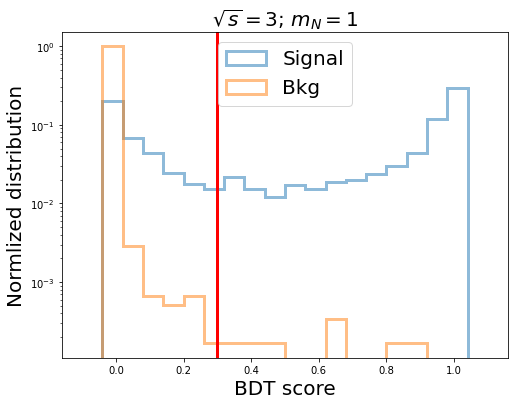

In [53]:
# BDT score distribution 

f = plt.figure(figsize=(8,6))
# f = plt.figure(figsize=(15,6))
ax1 = plt.subplot(111)

df_plot = df_bdt_test_s
# df_plot = df_bdt_train_s

pred0_max = df_plot[(df_plot.target==1)]['preds'].max() 
pred0_min = df_plot[(df_plot.target==1)]['preds'].min() 
pred0_diff = pred0_max - pred0_min
range_=[pred0_min - 0.1*pred0_max, pred0_max + 0.1*pred0_diff]

bins_=20

ax1.hist(df_plot[(df_plot.target==1)]['preds'], weights=df_plot[df_plot.target==1]['weight']/sum(df_plot[df_plot.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_plot[(df_plot.target==0)]['preds'], weights=df_plot[df_plot.target==0]['weight']/sum(df_plot[df_plot.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Bkg', alpha=0.5);

ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'BDT score', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=9, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)

ax1.set_yscale('log')

# threshold = 0.4
threshold = 0.3
# threshold = 0.275

ax1.axvline(threshold, color='red', lw=3)


# =================================================================================
# Apply BDT score cut
df_bdt_cut = df_bdt_test_s[(df_bdt_test_s['preds'] >= threshold)]
# =================================================================================



In [54]:

df_bdt_cut['target'] = df_test_o.loc[df_bdt_cut.index]['target']
df_bdt_cut['iEvt'] = df_test_o.loc[df_bdt_cut.index]['iEvt']
df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] == 0)]
df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]
df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]
df_bdt_cut3 = df_bdt_cut[(df_bdt_cut['target'] == 3)]
df_bdt_cut4 = df_bdt_cut[(df_bdt_cut['target'] == 4)]

df_bdt_cut0['mN'] = df_test_o.loc[df_bdt_cut0.index]['mN']
df_bdt_cut1['mN'] = df_test_o.loc[df_bdt_cut1.index]['mN']
df_bdt_cut2['mN'] = df_test_o.loc[df_bdt_cut2.index]['mN']
df_bdt_cut3['mN'] = df_test_o.loc[df_bdt_cut3.index]['mN']
df_bdt_cut4['mN'] = df_test_o.loc[df_bdt_cut4.index]['mN']


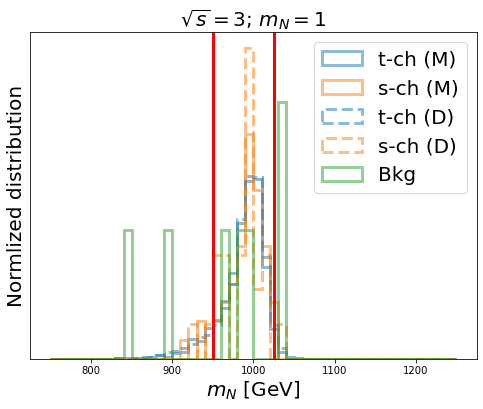

In [55]:
# mN distribution after BDT cut

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

range_ = [mN*(1-0.25)*1000, mN*(1+0.25)*1000]

col = 'm'
particle = 'N'

bins_=50
ax1.hist(df_bdt_cut1[col+particle], weights=[1/len(df_bdt_cut1)]*len(df_bdt_cut1), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (M)', color='C0');
ax1.hist(df_bdt_cut2[col+particle], weights=[1/len(df_bdt_cut2)]*len(df_bdt_cut2), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='s-ch (M)', color='C1');
ax1.hist(df_bdt_cut3[col+particle], weights=[1/len(df_bdt_cut3)]*len(df_bdt_cut3), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='t-ch (D)', color='C0', linestyle='--');
ax1.hist(df_bdt_cut4[col+particle], weights=[1/len(df_bdt_cut4)]*len(df_bdt_cut4), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='s-ch (D)', color='C1', linestyle='--');
ax1.hist(df_bdt_cut0[col+particle], weights=[1/len(df_bdt_cut0)]*len(df_bdt_cut0), bins=bins_, range=range_, histtype='step', alpha=0.5, lw=3, label='Bkg', color='C2');


ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$m_N ~[\rmGeV]$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)


# partition_u = 0.05
partition_u = 0.025
# partition_u = 0.1
# partition_l = 0.1
partition_l = 0.05
ax1.axvline(1000*mN*(1-partition_l), color='red', lw=3)
ax1.axvline(1000*mN*(1+partition_u), color='red', lw=3)

# f.savefig('./figures/mN')


# =========================================================================================
# manully apply cut on mN
df_bdt_cut['mN'] = df_test_o.loc[df_bdt_cut.index]['mN']
df_bdt_cut = df_bdt_cut[(df_bdt_cut.mN>=1000*mN*(1-partition_l)) & (df_bdt_cut.mN<=1000*mN*(1+partition_u))]
# df_bdt_cut = df_bdt_cut[(df_bdt_cut.mN>=1800) & (df_bdt_cut.mN<=2200)]
# =========================================================================================



In [56]:
df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] == 0)]   # Bkg
df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]   # t-ch M
df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]   # s-ch M
df_bdt_cut3 = df_bdt_cut[(df_bdt_cut['target'] == 3)]   # t-ch D
df_bdt_cut4 = df_bdt_cut[(df_bdt_cut['target'] == 4)]   # s-ch D

# yield (without |V|^2 dependence)
nb = df_bdt_cut0.weight.sum() / tr_te_size          # Bkg
ntM = df_bdt_cut1.weight.sum() / tr_te_size / V2    # t-ch M
nsM = df_bdt_cut2.weight.sum() / tr_te_size / V2    # s-ch M
ntD = df_bdt_cut3.weight.sum() / tr_te_size / V2    # t-ch D
nsD = df_bdt_cut4.weight.sum() / tr_te_size / V2    # s-ch D

nM = nsM + ntM    # total M
nD = nsD + ntD    # total D

print('yields: ')
print(f'Bkg:\t{nb:.2e}')
print(f'(M):\t{nM:.2e}')
print(f'(D):\t{nD:.2e}')
print(f'  t-ch (M):\t{ntM:.2e}')
print(f'  s-ch (M):\t{nsM:.2e}')
print(f'  t-ch (D):\t{ntD:.2e}')
print(f'  s-ch (D):\t{nsD:.2e}')

yields: 
Bkg:	1.00e+02
(M):	6.70e+06
(D):	6.04e+06
  t-ch (M):	6.70e+06
  s-ch (M):	2.74e+01
  t-ch (D):	6.04e+06
  s-ch (D):	1.42e+01


In [59]:
N = 1.96
# N = 1.645
M = N**2

print('Fully Majorana case:')
upperM, lowerM = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nM), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nM)
print(f"upper limit on |V|^2: {upperM:.2e}")
print(f"lower limit on |V|^2: {lowerM:.2e}")
print()

print('Fully Dirac case:')
upperD, lowerD = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nD), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nD)
print(f"upper limit on |V|^2: {upperD:.2e}")
print(f"lower limit on |V|^2: {lowerD:.2e}")

Fully Majorana case:
upper limit on |V|^2: 3.23e-06
lower limit on |V|^2: -2.66e-06

Fully Dirac case:
upper limit on |V|^2: 3.59e-06
lower limit on |V|^2: -2.95e-06


In [25]:
b = nb
s = nM

(chi2.ppf(0.95, df=2*(b + 1))/2 - b) / s

2.70481775208554e-06

In [26]:
eff0, eff1, eff2, eff3, eff4 = \
len(df_bdt_cut0) / len(df_test_o[df_test_o.target==0]), \
len(df_bdt_cut1) / len(df_test_o[df_test_o.target==1]), \
len(df_bdt_cut2) / len(df_test_o[df_test_o.target==2]), \
len(df_bdt_cut3) / len(df_test_o[df_test_o.target==3]), \
len(df_bdt_cut4) / len(df_test_o[df_test_o.target==4])

print("BDT eff:")
print("bkg:\t\t{:2f}%".format(100*eff0))
print("t-ch (M):\t{:2f}%".format(100*eff1))
# print("s-ch (M):\t{:2f}%".format(100*eff2))
print("t-ch (D):\t{:2f}%".format(100*eff3))
# print("s-ch (D):\t{:2f}%".format(100*eff4))

BDT eff:
bkg:		0.050386%
t-ch (M):	55.380301%
t-ch (D):	47.679181%


In [27]:
print("s/b ratio: ")
print(f'# Maj signal / bkg = {nM/nb:.0f} x |V|^2')
print(f'# Dir signal / bkg = {nD/nb:.0f} x |V|^2')

s/b ratio: 
# Maj signal / bkg = 66659 x |V|^2
# Dir signal / bkg = 60050 x |V|^2


In [28]:
print("s/sqrt(b) ratio: ")
print(f'# Maj signal / sqrt(bkg) = {nM/(nb)**0.5:.0f} x |V|^2')
print(f'# Dir signal / sqrt(bkg) = {nD/(nb)**0.5:.0f} x |V|^2')

s/sqrt(b) ratio: 
# Maj signal / sqrt(bkg) = 668254 x |V|^2
# Dir signal / sqrt(bkg) = 602002 x |V|^2


In [63]:
d = xgbc1.get_booster().get_score()
dict(sorted(d.items(), key=lambda item: -1*item[1]))

{'pzN': 341.0,
 'ELep': 201.0,
 'ptJJ': 189.0,
 'ptLep': 182.0,
 'DeltaRjjl': 180.0,
 'EJet2': 133.0,
 'ptN': 127.0,
 'etaJJ': 110.0,
 'etaLep': 84.0,
 'DeltaPhijjl': 77.0,
 'EJet1': 74.0,
 'mJJ': 58.0,
 'chargeLep': 28.0}

In [64]:
df_bdt_cut

,target,weight,preds,iEvt,mN
1,1,2.120000e-03,0.997973,9284,1007.094482
2,1,2.120000e-03,0.975062,3062,988.581970
4,1,2.120000e-03,0.336463,2110,969.886353
5,1,2.120000e-03,0.999981,7962,986.453857
6,1,2.120000e-03,0.997075,2891,977.315430
...,...,...,...,...,...
11832,4,3.090000e-07,0.936292,6794,1005.464844
11852,4,3.090000e-07,0.934861,5638,950.866516
12487,0,1.675000e+01,0.376872,102925,986.094788
12987,0,1.675000e+01,0.678689,165397,992.641846


In [65]:

df_bdt_test_s['target'] = df_test_o.loc[df_bdt_test_s.index]['target']
df_bdt_test_s.loc[:, 'pred1'] = xgbc1.predict_proba(X_test)[:, 1]
df_bdt_test_s.loc[:, 'pred2'] = xgbc1.predict_proba(X_test)[:, 2]

df_bdt_test_s['target'] = df_bdt_test_s['target'].apply(relabel)

In [66]:
df_bdt_test_s = df_bdt_test_s.loc[df_bdt_cut.index]

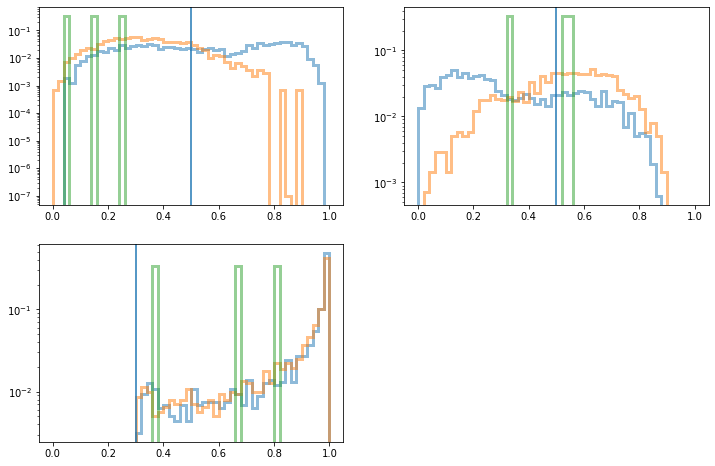

In [67]:
plt.figure(figsize=(12,8))

ax1 = plt.subplot(221)
range_=[0,1]
bins_=50

ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax1.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred1'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
cutM=0.5
ax1.axvline(cutM)
ax1.set_yscale('log')

ax2 = plt.subplot(222)
range_=[0,1]
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax2.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
cutD=0.5
ax2.axvline(cutD)
ax2.set_yscale('log')


ax3 = plt.subplot(223)
range_=[0,1]
ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==1)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==1)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==1]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==1]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==2)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==2)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==2]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==2]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
ax3.hist(df_bdt_test_s[(df_bdt_test_s.target==0)]['pred1']+df_bdt_test_s[(df_bdt_test_s.target==0)]['pred2'], weights=df_bdt_test_s[df_bdt_test_s.target==0]['weight']/sum(df_bdt_test_s[df_bdt_test_s.target==0]['weight']), bins=bins_, range=range_, histtype='step', lw=3, label=r'Signal', alpha=0.5);
# cutD=0.5
ax3.axvline(threshold)
ax3.set_yscale('log')

In [68]:
df_bdt_test_s[(df_bdt_test_s.pred1<=cutM) & (df_bdt_test_s.pred2>cutD) & (df_bdt_test_s.target==0)]

,target,weight,preds,pred1,pred2
12987,0,16.75,0.678689,0.157633,0.521055
13009,0,16.75,0.807569,0.251386,0.556182


In [69]:
def get_M_block(V2_test=1e-5):
    df_M = df_bdt_test_s[(df_bdt_test_s.pred1>cutM) & (df_bdt_test_s.pred2<=cutD)]
    M0, M1, M2 = df_M[df_M.target==0].weight.sum()/tr_te_size, df_M[df_M.target==1].weight.sum()/tr_te_size, df_M[df_M.target==2].weight.sum()/tr_te_size
    M1, M2 = M1/V2*V2_test, M2/V2*V2_test
    return M0, M1, M2

def get_D_block(V2_test=1e-5):
    df_D = df_bdt_test_s[(df_bdt_test_s.pred1<=cutM) & (df_bdt_test_s.pred2>cutD)]
    D0, D1, D2 = df_D[df_D.target==0].weight.sum()/tr_te_size, df_D[df_D.target==1].weight.sum()/tr_te_size, df_D[df_D.target==2].weight.sum()/tr_te_size
    D1, D2 = D1/V2*V2_test, D2/V2*V2_test
    return D0, D1, D2

    
def N_M(r, M_M, D_M, B_M):
    return r*M_M + (1-r)*D_M + B_M
    
def N_D(r, M_D, D_D, B_D):
    return r*D_D + (1-r)*M_D + B_D
    
    
def lnL(r, r_t, M_M, D_M, B_M, M_D, D_D, B_D):
    NM = N_M(r, M_M, D_M, B_M)
    NMt = N_M(r_t, M_M, D_M, B_M)
    ND = N_D(r, M_D, D_D, B_D)
    NDt = N_D(r_t, M_D, D_D, B_D)
    
    
    lnL_M = (NMt)*np.log(NM) - (NMt*np.log(NMt)-NMt) - NM
    lnL_D = (NDt)*np.log(ND) - (NDt*np.log(NDt)-NDt) - ND
    return lnL_M + lnL_D

In [70]:
M0, M1, M2 = get_M_block(V2_lim)
D0, D1, D2 = get_D_block(V2_lim)

print(f"Majorana region: B:{M0}; M:{M1}; D:{M2}")
print(f"Dirac region:    B:{D0}; M:{D1}; D:{D2}")

NameError: name 'V2_lim' is not defined

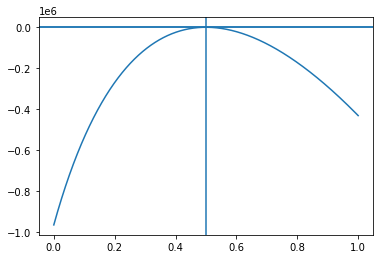

In [71]:
r = np.arange(0, 1.00000000001, 0.0001)

rt = 0.5   # if the measured data is such value
lnL_val = lnL(r, rt, M1, M2, M0, D1, D2, D0)

plt.plot(r, lnL_val)    # loop over possible r, to find the one max the liklihood
plt.axvline(rt)
plt.axhline(np.max(lnL_val))
plt.axhline(np.max(lnL_val)-1/2)

i_r = np.argmin(abs(lnL_val[np.argmax(lnL_val):] - (np.max(lnL_val)-1/2))) + np.argmax(lnL_val) 
if abs(np.max(lnL_val)-1/2 / lnL_val[i_r] - 1) < 1/100:
    plt.axvline(r[i_r])

i_l = np.argmin(abs(lnL_val[:np.argmax(lnL_val)] - (np.max(lnL_val)-1/2)))
if abs(np.max(lnL_val)-1/2 / lnL_val[i_l] - 1) < 1/100:
    plt.axvline(r[i_l])


In [72]:
V2_test = 1e-4
M0, M1, M2 = get_M_block(V2_test)
D0, D1, D2 = get_D_block(V2_test)

r = np.arange(0, 1.0000000001, 0.0001)
rt_lt = np.arange(0, 1.00000000001, 0.01)


def get_bounds(r, sd):
    
    sig = sd**2
    upper_lt = []
    lower_lt = []


    for i, rt in enumerate(rt_lt):
        if i%100 == 0:
            print(rt, end='\r')
        lnL_val = lnL(r, rt, M1, M2, M0, D1, D2, D0)

        if rt == 1:
            upper_lt.append(np.nan)
        else:
            i_r = np.argmin(abs(lnL_val[np.argmax(lnL_val):] - (np.max(lnL_val)-sig/2))) + np.argmax(lnL_val) 
            if abs(np.max(lnL_val)-sig/2 / lnL_val[i_r] - 1) < 1/100:
                upper_lt.append(r[i_r])
            else: 
                upper_lt.append(np.nan)
        
        if rt == 0:
            lower_lt.append(np.nan)
        else:
            i_l = np.argmin(abs(lnL_val[:np.argmax(lnL_val)] - (np.max(lnL_val)-sig/2)))
            if abs(np.max(lnL_val)-sig/2 / lnL_val[i_l] - 1) < 1/100:
                lower_lt.append(r[i_l])
            else: 
                lower_lt.append(np.nan)
    
    upper_lt, lower_lt = np.array(upper_lt), np.array(lower_lt)
#     upper_lt[np.isnan(upper_lt)] = 1
#     lower_lt[np.isnan(lower_lt)] = 0
    return upper_lt, lower_lt

In [73]:
upper_lt1, lower_lt1 = get_bounds(r, 1)
upper_lt2, lower_lt2 = get_bounds(r, 2)

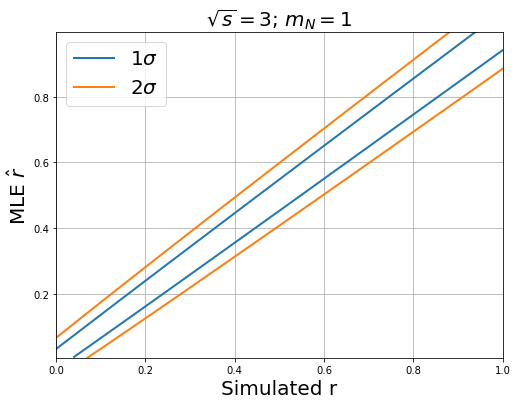

In [74]:

f = plt.figure(figsize=(8,6))
# plt.figure(figsize=(18,12))
# plt.figure(figsize=(12,8))

plt.plot(rt_lt, upper_lt1, color='C0', label=r'$1\sigma$', lw=2)
plt.plot(rt_lt, lower_lt1, color='C0', lw=2)

plt.plot(rt_lt, upper_lt2, color='C1', label=r'$2\sigma$', lw=2)
plt.plot(rt_lt, lower_lt2, color='C1', lw=2)

plt.legend(fontsize=20)

plt.title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)


plt.xlabel("Simulated r", fontsize=20);
plt.ylabel(r"MLE $\hat{r}$", fontsize=20);

plt.margins(y=0)
plt.margins(x=0)

# plt.axvline(0, c='black')
# plt.axvline(1, c='black')
# plt.axhline(0, c='black')
# plt.axhline(1, c='black')
plt.grid()


# plt.fill_between(rt_lt[1:], upper_lt2, lower_lt2, color='yellow')
# plt.fill_between(rt_lt[1:], upper_lt1, lower_lt1, color='green')
# plt.plot(rt_lt[1:], rt_lt[1:], color='black')


In [75]:
sigma_pos = upper_lt1 - rt_lt
sigma_neg = rt_lt - lower_lt1 

df_sigma = pd.DataFrame(columns=['r', 'sigma_pos', 'sigma_neg'])
df_sigma['r'] = rt_lt
df_sigma['sigma_pos'] = sigma_pos
df_sigma['sigma_neg'] = sigma_neg

df_sigma_pos = df_sigma[['r', 'sigma_pos']].dropna()
df_sigma_neg = df_sigma[['r', 'sigma_neg']].dropna()


In [76]:
df_sigma['avg'] = df_sigma[['sigma_pos', 'sigma_neg']].mean(axis=1)
# df_sigma = df_sigma.dropna()

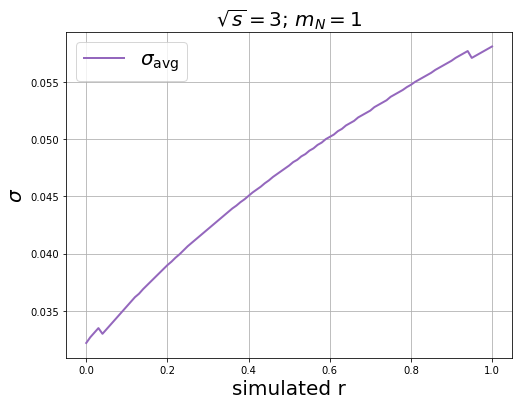

In [77]:

f = plt.figure(figsize=(8,6))
plt.plot(df_sigma['r'], df_sigma['avg'], lw=2, c='C4', label=r'$\sigma_{\rm avg}$')
# plt.plot(df_sigma['r'], df_sigma['sigma_pos'], lw=2, c='C2', label=r'$\sigma_+$')
# plt.plot(df_sigma['r'], df_sigma['sigma_neg'], lw=2, c='C3', label=r'$\sigma_-$')
# plt.plot(rt_lt, upper_lt1-lower_lt1, lw=2)
plt.legend(fontsize=20)

plt.xlabel("simulated r", fontsize=20);
# plt.ylabel(r"$\sigma_+ - \sigma_-$", fontsize=20);
plt.ylabel(r"$\sigma$", fontsize=20);
plt.title(r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
plt.xlim(-0.05, 1.05)
plt.grid()

In [78]:
# width_thre = 0.1
# sig = 1

# r = np.arange(0, 1.0000000001, 0.0001)
# rt_lt = np.arange(0, 1.00000000001, 0.01)

# V2_dt = {}

# # verbose = 1
# verbose = 0

# for i, rt in enumerate(rt_lt[1:]):
# # for i, rt in enumerate(r[249:]):

#     if not verbose: print(i, rt, "............................................................................................", end='\r')
#     else: print(i, rt, "............................................................................................")
    
    
#     V2_test = 1e-3
#     while True:
#         M0, M1, M2 = get_M_block(V2_test)
#         D0, D1, D2 = get_D_block(V2_test)

#         upper_lt = []
#         lower_lt = []

#         lnL_val = lnL(r, rt, M1, M2, M0, D1, D2, D0)

#         i_r = np.argmin(abs(lnL_val[np.argmax(lnL_val):] - (np.max(lnL_val)-sig/2))) + np.argmax(lnL_val) 
#         if abs(np.max(lnL_val)-sig/2 / lnL_val[i_r] - 1) < 1/100:
#             upper_lt.append(r[i_r])
#         else: 
#             upper_lt.append(np.nan)


#         i_l = np.argmin(abs(lnL_val[:np.argmax(lnL_val)] - (np.max(lnL_val)-sig/2)))
#         if abs(np.max(lnL_val)-sig/2 / lnL_val[i_l] - 1) < 1/100:
#             lower_lt.append(r[i_l])
#         else: 
#             lower_lt.append(np.nan)

#         upper_lt, lower_lt = np.array(upper_lt), np.array(lower_lt)
#         upper_lt[np.isnan(upper_lt)] = 1
#         lower_lt[np.isnan(lower_lt)] = 0

#         width = (upper_lt - lower_lt)[0]
#         if verbose: print(V2_test, width, round(abs(width / width_thre - 1), 8), round(abs(width / width_thre - 1), 8) < 1/100)
#         if round(abs(width / width_thre - 1), 8) < 1/100:
#             if verbose: print("============================================================================================================")
#             V2_dt[rt] = V2_test
#             break
            
#         if width < width_thre and abs(width / width_thre - 1) < 10/100:
#             if verbose: print("/5")
#             V2_test /= (5* (1 + np.random.normal(0, 0.1)))
#         elif width < width_thre and abs(width / width_thre - 1) < 50/100:
#             if verbose: print("/10")
#             V2_test /= (10* (1 + np.random.normal(0, 0.1)))
#         elif width < width_thre :
#             if verbose: print("/20")
#             V2_test /= (20* (1 + np.random.normal(0, 0.1)))
            
#         else:
#             V2_test = 10**(np.log10(V2_test)*0.999) 

In [79]:

# f = plt.figure(figsize=(8,6))
# plt.plot(V2_dt.keys(), V2_dt.values(), lw=2)
# plt.yscale('log')
# plt.margins(y=0.25)
# # plt.ylim(1e-5, 1.5e-4)
# # plt.ylim(1e-5, 1e-3)

# # ax1.set_title(, fontsize=20)
# plt.title(r"min. $|V|^2$ to have $(\sigma_+ - \sigma_-) \leq 0.1$"+"\n"+r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
# plt.xlabel("simulated r", fontsize=20);
# plt.ylabel(r"$|V|^2$", fontsize=20);
# plt.grid()

In [80]:
def get_limit(r0=1, sd=1):

    rt_lt = np.arange(0,1.00000000001,0.01)

    V2_dt = {}
    for rt in rt_lt:
        if rt==r0:
            V2_dt[rt] = np.nan
#             print("..")
            continue
            
        V2_test = 1e-3
        print(rt, end='\r')
        while True:
            M0, M1, M2 = get_M_block(V2_test)
            D0, D1, D2 = get_D_block(V2_test)
            lnL_valr = lnL(rt, rt, M1, M2, M0, D1, D2, D0)
            lnL_val0 = lnL(r0, rt, M1, M2, M0, D1, D2, D0)
            Z = (-2*(lnL_val0 - lnL_valr))**0.5

            if abs(Z/sd-1) < 0.5/100:
                V2_dt[rt] = V2_test
                break
            elif Z > sd:
                V2_test /= 2
            elif Z < sd:
                V2_test = 10**(np.log10(V2_test)*0.999) 
    return V2_dt

In [81]:
# V2_dt_r0_1sd = get_limit(r0=0, sd=1.)
# V2_dt_r1_1sd = get_limit(r0=1, sd=1.)

V2_dt_r0_2sd = get_limit(r0=0, sd=2.)
V2_dt_r1_2sd = get_limit(r0=1, sd=2.)

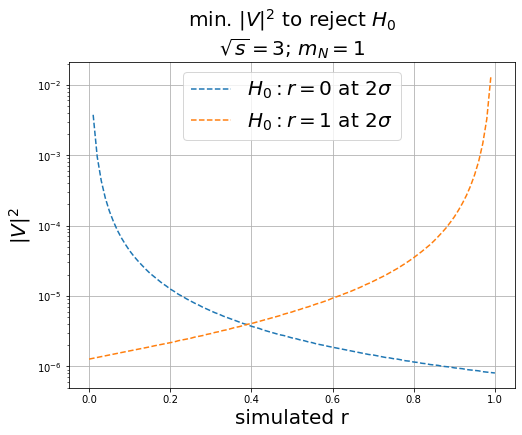

In [83]:

f = plt.figure(figsize=(8,6))
# plt.plot(V2_dt_r0_1sd.keys(), V2_dt_r0_1sd.values(), label=r'$H_0: r=0$ at $1\sigma$', c='C0')
# plt.plot(V2_dt_r1_1sd.keys(), V2_dt_r1_1sd.values(), label=r'$H_0: r=1$ at $1\sigma$', c='C1')
plt.plot(V2_dt_r0_2sd.keys(), V2_dt_r0_2sd.values(), label=r'$H_0: r=0$ at $2\sigma$', c='C0', linestyle='--')
plt.plot(V2_dt_r1_2sd.keys(), V2_dt_r1_2sd.values(), label=r'$H_0: r=1$ at $2\sigma$', c='C1', linestyle='--')
plt.yscale('log')
# plt.margins(y=0.25)

plt.title(r"min. $|V|^2$ to reject $H_0$"+"\n"+r"$\sqrt{s}=$"+str(cm)+"; $m_N=$"+str(mN), fontsize=20)
plt.xlabel("simulated r", fontsize=20);
plt.ylabel(r"$|V|^2$", fontsize=20);
plt.grid()
plt.legend(fontsize=20)

plt.yscale('log')

In [62]:
M0, M1, M2 = get_M_block(8.051046480648566e-07)
D0, D1, D2 = get_D_block(8.051046480648566e-07)

print(f"Majorana region: B:{M0}; M:{M1}; D:{M2}")
print(f"Dirac region:    B:{D0}; M:{D1}; D:{D2}")

Majorana region: B:0.0; M:2.939157511987635; D:0.6990934435544011
Dirac region:    B:67.0; M:1.4985935037510099; D:2.966781409261108


In [42]:
# df_bdt_cut0 = df_bdt_cut[(df_bdt_cut['target'] == 0)]   # Bkg
# df_bdt_cut1 = df_bdt_cut[(df_bdt_cut['target'] == 1)]   # t-ch M
# df_bdt_cut2 = df_bdt_cut[(df_bdt_cut['target'] == 2)]   # s-ch M
# df_bdt_cut3 = df_bdt_cut[(df_bdt_cut['target'] == 3)]   # t-ch D
# df_bdt_cut4 = df_bdt_cut[(df_bdt_cut['target'] == 4)]   # s-ch D

# yield (without |V|^2 dependence)
# nb = df_bdt_cut0.weight.sum() / tr_te_size          # Bkg
# ntM = df_bdt_cut1.weight.sum() / tr_te_size / V2    # t-ch M
# nsM = df_bdt_cut2.weight.sum() / tr_te_size / V2    # s-ch M
# ntD = df_bdt_cut3.weight.sum() / tr_te_size / V2    # t-ch D
# nsD = df_bdt_cut4.weight.sum() / tr_te_size / V2    # s-ch D

M0, M1, M2 = get_M_block(1)
D0, D1, D2 = get_D_block(1)

nb = M0 + D0
nM = M2 + D2
nD = M1 + D1

# nM = nsM + ntM    # total M
# nD = nsD + ntD    # total D

print('yields: ')
print(f'Bkg:\t{nb:.2e}')
print(f'(M):\t{nM:.2e}')
print(f'(D):\t{nD:.2e}')
print(f'  t-ch (M):\t{ntM:.2e}')
print(f'  s-ch (M):\t{nsM:.2e}')
print(f'  t-ch (D):\t{ntD:.2e}')
print(f'  s-ch (D):\t{nsD:.2e}')

N = 1.96
# N = 1.645
M = N**2

print('Fully Majorana case:')
upperM, lowerM = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nM), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nM)
print(f"upper limit on |V|^2: {upperM:.2e}")
print(f"lower limit on |V|^2: {lowerM:.2e}")
print()

print('Fully Dirac case:')
upperD, lowerD = ((M+(M**2 + 4*M*nb)**0.5)/2)/(nD), ((M-(M**2 + 4*M*nb)**0.5)/2)/(nD)
print(f"upper limit on |V|^2: {upperD:.2e}")
print(f"lower limit on |V|^2: {lowerD:.2e}")

yields: 
Bkg:	6.70e+01
(M):	4.55e+06
(D):	5.51e+06
  t-ch (M):	6.70e+06
  s-ch (M):	2.74e+01
  t-ch (D):	6.04e+06
  s-ch (D):	1.42e+01
Fully Majorana case:
upper limit on |V|^2: 3.97e-06
lower limit on |V|^2: -3.13e-06

Fully Dirac case:
upper limit on |V|^2: 3.28e-06
lower limit on |V|^2: -2.58e-06
